In [1]:
import sys
import os 
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [2]:
from utils.class_utils import CyboConfig, CexConfig
from utils.research_utils import ResearchEngine
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import json
import os

In [3]:
abs_config_path = "/Users/raysontan/Desktop/Projects/crypto_fund/V4/research/config"
with open(os.path.join(abs_config_path, "db_config.json")) as f:
    db_config = json.load(f)
engine = ResearchEngine(db_config) 

In [4]:
start_time=datetime(2021, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
end_time=datetime(2023, 3, 1, 0, 0, 0, tzinfo=timezone.utc)

In [5]:
config = CexConfig(
    exchange="Bybit",
    endpoint="/v5/market/kline",
    category="linear",
    interval="1h",
    inst="BTCUSDT",
)

df_y = await engine.get_data(start_time,end_time,config)
print("Done")

Running as CEX instance
Request matched, getting df...
Processing DF
Done


In [6]:
config = CyboConfig(
    provider="glassnode",
    endpoint="v1/metrics/addresses/loss_count",
    interval="1h",
    inst="BTC",
    exchange=''
)

df_x = await engine.get_data(start_time,end_time,config)
print("Done")

Running as Cybo instance
Request matched, getting DF...
Finished data fetching, processing DF...
Done


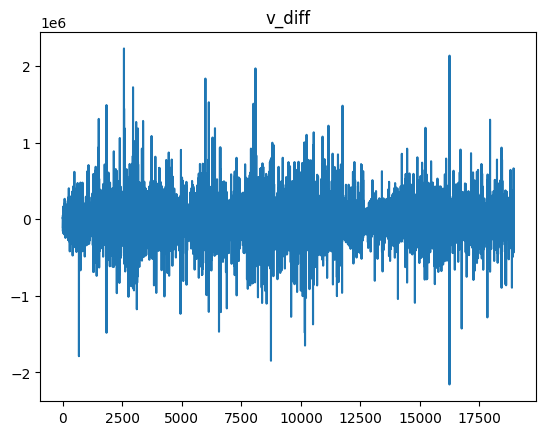

In [22]:
df_x["v"] = df_x["v"].apply(lambda x: pd.to_numeric(x))
df_x["v_diff"] = df_x["v"].diff() 

X = df_x["v_diff"]

X.plot(title="v_diff")
plt.show()

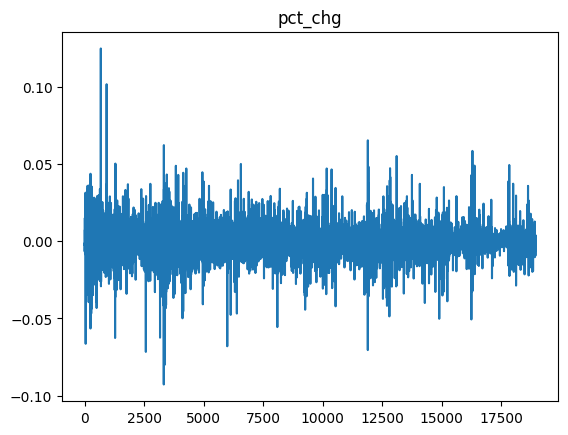

In [23]:
df_y["pct_chg"] = df_y["close"].pct_change()

Y = df_y["pct_chg"]

Y.plot(title="pct_chg")
plt.show()

X Shape: (18936, 1)
[[-143926.]
 [  20946.]
 [  -2001.]
 ...
 [-433886.]
 [ 231322.]
 [-164314.]]
Y Shape: (18936, 1)
[[ 0.01452225]
 [-0.00656217]
 [ 0.00290917]
 ...
 [ 0.00078681]
 [-0.00084667]
 [-0.00143537]]


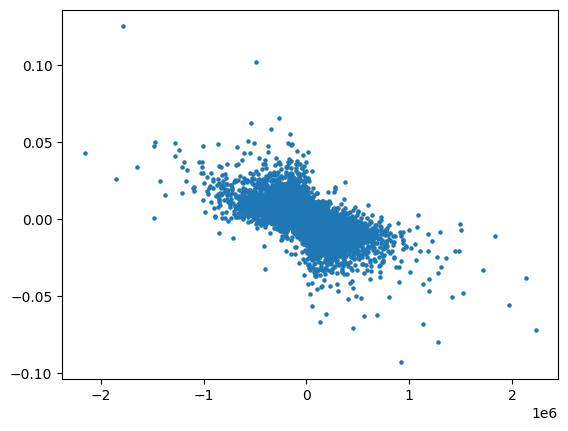

In [24]:
X = X.dropna().reset_index(drop=True)
Y = Y.dropna().reset_index(drop=True)

X = X.to_numpy()
Y = Y.to_numpy()

X = X.reshape(-1,1) # Reshape from 1D -> 2D 
Y = Y.reshape(-1,1) # Reshape from 1D -> 2D 

print(f"X Shape: {X.shape}")
print(X)
print(f"Y Shape: {Y.shape}")
print(Y)
plt.scatter(X,Y, s=5)

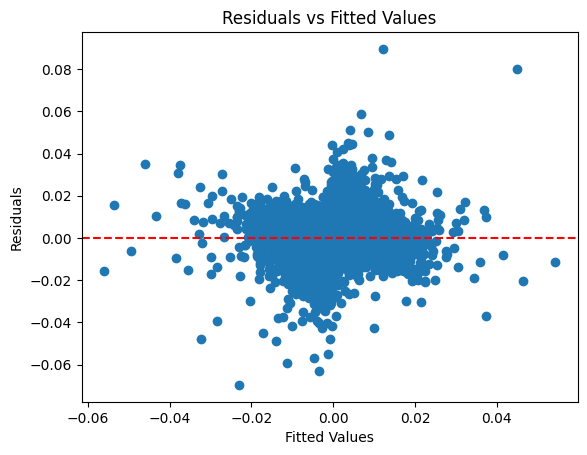

In [ ]:
from sklearn.linear_model import LinearRegression

# Assuming X and y are your data
model = LinearRegression().fit(X, Y)
y_pred = model.predict(X)
residuals = Y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values') 
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

In [15]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

X_with_const = sm.add_constant(X)  # Add intercept term
model = sm.OLS(Y, X_with_const).fit()
bp_test = het_breuschpagan(model.resid, X_with_const)
print('Breusch-Pagan test p-value:', bp_test[1])

Breusch-Pagan test p-value: 0.6465285900904776


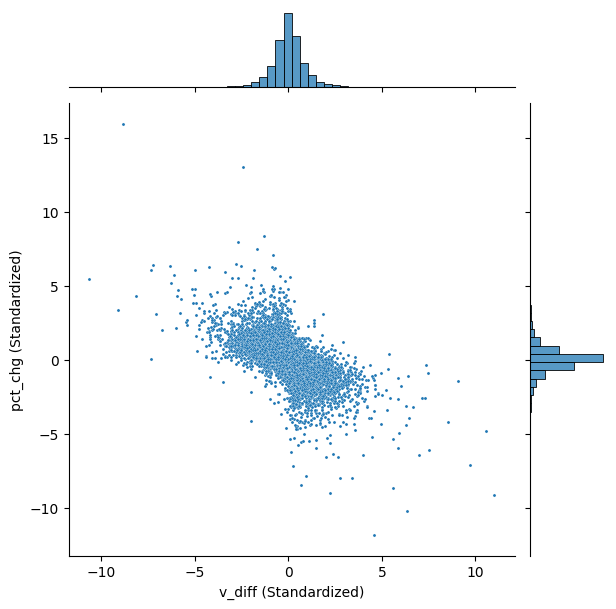

In [11]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y)

x_flatten = x_scaled.flatten()
y_flatten = y_scaled.flatten()

# Create jointplot with KDE marginals
sns.jointplot(x=x_flatten, y=y_flatten, kind='scatter', marginal_kws={'bins': 50, 'fill': True}, 
              s=5)
plt.xlabel('v_diff (Standardized)')
plt.ylabel('pct_chg (Standardized)')
# plt.suptitle('Scatter Plot with Marginal Distributions', y=1.02)
plt.show()

### Gradient Descent 
- In this version, we're no longer calculating all possible value combinations into a heatmap
- We initialize random parameters and keep changing the params in the direction that most reduces / maximizes the "Target Metric" (MSE Cost, Sharpe, ...)

In [ ]:
def compute_cost(x,y,w,b):
    '''
    Mean Squared Error : mean(sum(squared_err[i])) for i in range(m)
    '''
    m = x.shape[0]
    sse = 0 
    for i in range(m):
        y_pred = w * x[i] + b 
        sse += (y_pred - y[i])**2 
    mse = sse / m 
    return pd.Series([w,b,mse], index=["w","b","mse"])

def compute_gradient(x,y,w,b):
    '''
    Gradient : mean(sum(partial_derivatives[i])) for i in range(m)
    '''
    m = x.shape[0]

    dj_dw = 0 
    dj_db = 0
    for i in range(m):
        y_pred = w * x[i] + b 

        # Partial Derivative Formula
        dj_dw_i = (y_pred - y[i]) * x[i]
        dj_db_i = (y_pred - y[i]) 

        # Summation 
        dj_dw += dj_dw_i
        dj_db += dj_db_i
    
    # Final Gradient for param w, b
    dj_dw = dj_dw / m 
    dj_db = dj_db / m 

    return dj_dw, dj_db

##### Creating grid for $w$ & $b$ parameters
* $W$ = [\
    [-10.0, -9.59183673, -9.18367347, ..., 9.18367347, 9.59183673, 10.0],\
    [-10.0, -9.59183673, -9.18367347, ..., 9.18367347, 9.59183673, 10.0],\
    ... (all same rows)\
    ]
    
    
* $B$ = [\
    [-10.0, -10.0, -10.0, ..., -10.0, -10.0, -10.0,],\
    [-9.59183673, -9.59183673, -9.59183673, ..., -9.59183673, -9.59183673, -9.59183673],\
    ... (all same columns)\
    ]

In [13]:
w_range = np.linspace(-10, 10, 50) 
b_range = np.linspace(-10, 10, 50) 
W, B = np.meshgrid(w_range, b_range)
# J = np.zeros(W.shape)

### Gradient 
* The gradient is a partial derivative which is a derivative slope with respect to parameter x that corresponds to the inflicted rate of change for y output value dependent on parameter x. 

##### $$ \nabla f = (\frac{\partial j}{\partial w} , \frac{\partial j}{\partial b}) $$

$\frac{\partial j}{\partial w}$ : How much cost J changes by adjusting $w$

$\frac{\partial j}{\partial b}$ : How much cost J changes by adjusting $b$

In [14]:
result = [] 
for w in w_range:
    for b in b_range:
        result.append(compute_cost(x_scaled,y_scaled,w,b))
result_df = pd.DataFrame(result)
print(result_df)

         w          b                   mse
0    -10.0 -10.000000  [188.01291118947864]
1    -10.0  -9.591837  [180.01624313450273]
2    -10.0  -9.183673   [172.3527695818171]
3    -10.0  -8.775510  [165.02249053142026]
4    -10.0  -8.367347  [158.02540598331646]
...    ...        ...                   ...
2495  10.0   8.367347  [183.99958360435576]
2496  10.0   8.775510  [190.99666815246295]
2497  10.0   9.183673  [198.32694720285716]
2498  10.0   9.591837   [205.9904207555437]
2499  10.0  10.000000   [213.9870888105192]

[2500 rows x 3 columns]


In [15]:
result_df['mse'] = result_df['mse'].apply(lambda x: x[0])
pivot = result_df.pivot(index='b', columns='w', values='mse')

W = pivot.columns.values
B = pivot.index.values
W_grid, B_grid = np.meshgrid(W,B)
MSE_grid = pivot.values 

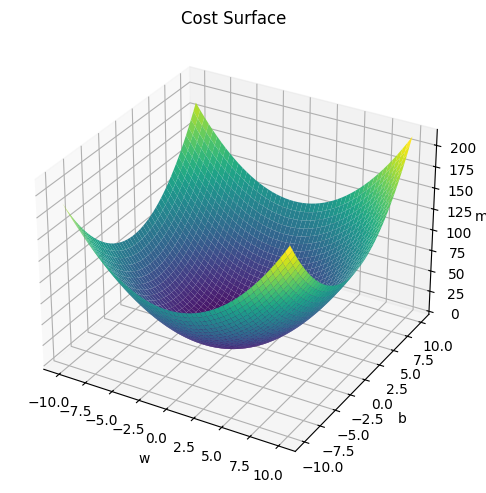

In [16]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(W_grid, B_grid, MSE_grid, cmap="viridis")

ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('mse')
plt.title('Cost Surface')
plt.tight_layout()
plt.show()

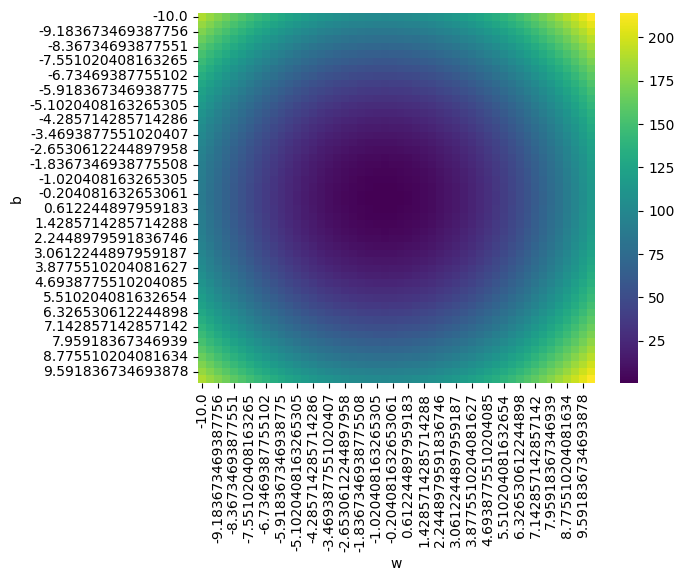

In [17]:
sns.heatmap(pivot,annot=False, cmap='viridis') #annotate
plt.show()

Text(0, 0.5, 'b')

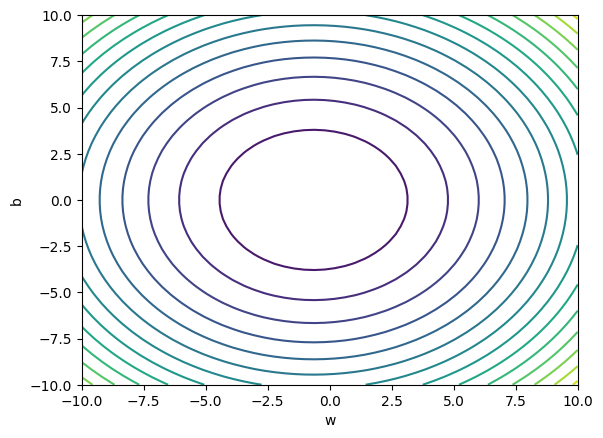

In [18]:
# 2D Contour plot with gradient vectors
plt.figure()
plt.contour(W_grid, B_grid, MSE_grid, levels=20, cmap='viridis')
plt.xlabel('w')
plt.ylabel('b')

### Gradient Descent 
* Initialize w and b parameters randomly
* Compute gradient for metric respective to w and b param
* Update parameters w and b to gradient direction with learning rate alpha 
* Repeat until convergence or for a specific num_iters 


In [34]:
def gradient_descent(x,y,w_init,b_init,alpha,num_iters):
    w = w_init
    b = b_init 

    learning_history = [] 

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(x,y,w,b)

        # Parameter update 
        w = w - alpha * dj_dw
        b = b - alpha * dj_db 

        # Learning history 
        learning_history.append(compute_cost(x,y,w,b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % 10 == 0:
            print(f"Iteration {i}: Cost {learning_history[-1][2]} ",
                  f"dj_dw: {dj_dw}, dj_db: {dj_db}  ",
                  f"w: {w}, b:{b}")
    
    return w, b, learning_history

In [35]:
w_init = 3
b_init = 3
num_iters = 100
alpha = 0.1 

w_final, b_final, learning_hist = gradient_descent(x_scaled, y_scaled, w_init, b_init, alpha, num_iters)

/var/folders/2q/l6yglhgn4qxf9tkrxs8yq2g40000gn/T/ipykernel_20286/4256128053.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Iteration {i}: Cost {learning_history[-1][2]} ",


Iteration 0: Cost [18.65574695]  dj_dw: [3.64935444], dj_db: [3.]   w: [2.63506456], b:[2.7]
Iteration 10: Cost [2.77612962]  dj_dw: [1.27245121], dj_db: [1.04603532]   w: [0.49585165], b:[0.94143179]
Iteration 20: Cost [0.84553886]  dj_dw: [0.4436763], dj_db: [0.36472996]   w: [-0.25004577], b:[0.32825697]
Iteration 30: Cost [0.6108241]  dj_dw: [0.15470036], dj_db: [0.12717347]   w: [-0.51012412], b:[0.11445613]
Iteration 40: Cost [0.58228826]  dj_dw: [0.05394068], dj_db: [0.04434265]   w: [-0.60080783], b:[0.03990838]
Iteration 50: Cost [0.57881897]  dj_dw: [0.01880795], dj_db: [0.01546133]   w: [-0.63242728], b:[0.01391519]
Iteration 60: Cost [0.57839719]  dj_dw: [0.00655793], dj_db: [0.00539103]   w: [-0.64345231], b:[0.00485193]
Iteration 70: Cost [0.57834591]  dj_dw: [0.00228661], dj_db: [0.00187974]   w: [-0.64729649], b:[0.00169176]
Iteration 80: Cost [0.57833967]  dj_dw: [0.00079729], dj_db: [0.00065542]   w: [-0.64863688], b:[0.00058988]
Iteration 90: Cost [0.57833892]  dj_dw

In [36]:
cleaned_data = [] 
for data in learning_hist:
    cleaned_data.append({
        'w': data['w'][0],
        'b': data['b'][0],
        'mse': data['mse'][0]
    })

# Create the DataFrame
learning_df = pd.DataFrame(cleaned_data)
learning_df

,w,b,mse
0,2.635065,2.700000,18.655747
1,2.306623,2.430000,15.221039
2,2.011025,2.187000,12.438926
3,1.744987,1.968300,10.185415
4,1.505553,1.771470,8.360070
...,...,...,...
95,-0.649207,0.000121,0.578339
96,-0.649221,0.000109,0.578339
97,-0.649235,0.000098,0.578339
98,-0.649247,0.000089,0.578339


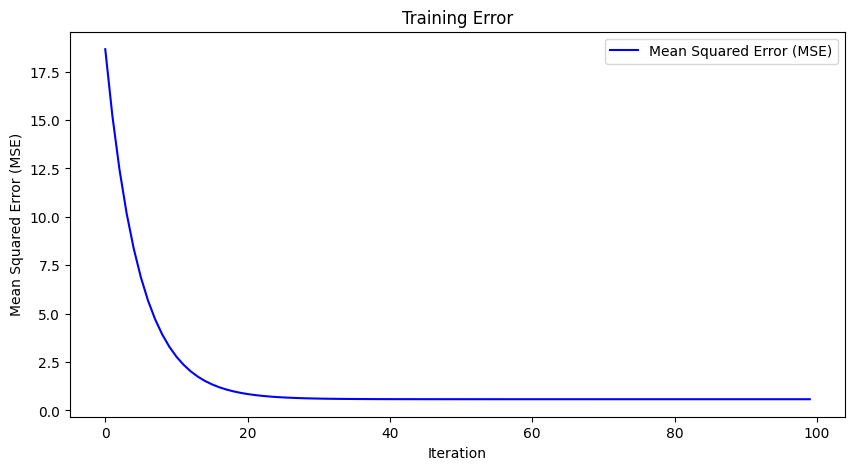

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(learning_df.index, learning_df['mse'], label='Mean Squared Error (MSE)', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Error')
plt.legend()
plt.show()

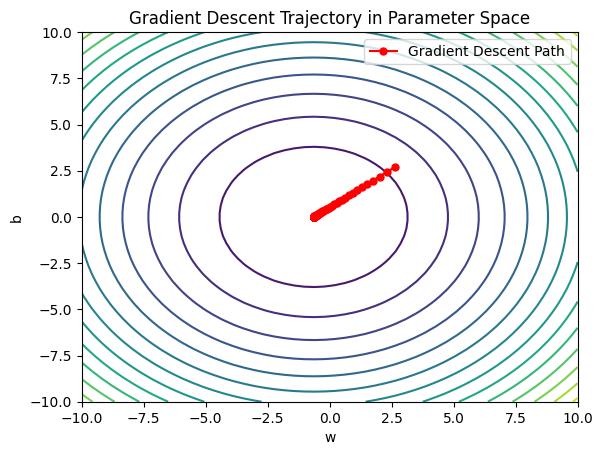

In [38]:
# 2D Contour plot with gradient vectors
plt.figure()
plt.contour(W_grid, B_grid, MSE_grid, levels=20, cmap='viridis')
plt.xlabel('w')
plt.ylabel('b')
plt.title('Gradient Descent Trajectory in Parameter Space')


# Extract w and b from learning_df
w_vals = learning_df['w'].values
b_vals = learning_df['b'].values
plt.plot(w_vals, b_vals, 'ro-', label='Gradient Descent Path', markersize=5)
# Adding arrows 
for i in range(len(w_vals) - 1):
    plt.arrow(w_vals[i], b_vals[i], 
              w_vals[i+1] - w_vals[i], b_vals[i+1] - b_vals[i], 
              head_width=0.05, head_length=0.05, fc='blue', ec='blue', alpha=0.6)
plt.legend()
plt.show()

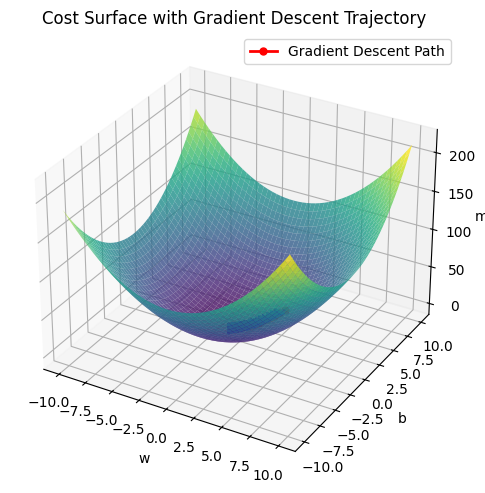

In [39]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(W_grid, B_grid, MSE_grid, cmap="viridis", alpha=0.8)

# Extract w, b, and mse from learning_df
w_vals = learning_df['w'].values
b_vals = learning_df['b'].values
mse_vals = learning_df['mse'].values

# Plot the gradient descent path
ax.plot(w_vals, b_vals, mse_vals, 'ro-', label='Gradient Descent Path', markersize=5, linewidth=2)

# Add directional indicators (simulated arrows) using short line segments
for i in range(len(w_vals) - 1):
    ax.plot([w_vals[i], w_vals[i+1]], 
            [b_vals[i], b_vals[i+1]], 
            [mse_vals[i], mse_vals[i+1]], 
            'b-', linewidth=2, alpha=0.6)  # Blue segments to indicate direction
    # Add a marker at the end of each segment to simulate arrowhead
    ax.scatter([w_vals[i+1]], [b_vals[i+1]], [mse_vals[i+1]], color='blue', s=50, marker='>')

ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('mse')
plt.title('Cost Surface with Gradient Descent Trajectory')
ax.legend()
plt.tight_layout()
plt.show()

y_pred = -0.64926 * x_i + 8e-05


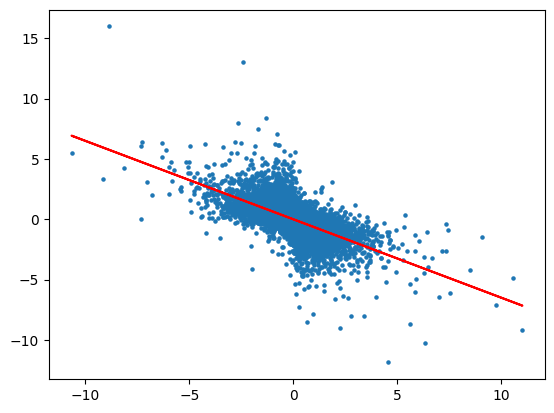

In [44]:
w = round(w_final[0], 5)
b = round(b_final[0], 5)

y_pred = w *x_scaled + b
print(f"y_pred = {w} * x_i + {b}")

plt.scatter(x_scaled, y_scaled, s=5)
plt.plot(x_scaled, y_pred, color='red', label=f'Regression Line\ny = {round(w,5)}x + {round(b,5)}')

### Model Diagnostics
A linear regression has 4 assumptions : 
* Normality of Errors 
* Homoskedasticity (Constant Variance) of Errors 
* Independence between observations

### Visualize "y_pred" Predicted Variables

R2 Score: 0.4216611741118682
Mean Squared Error: 0.5783388258881318
Mean Absolute Error: 0.47205862776869273


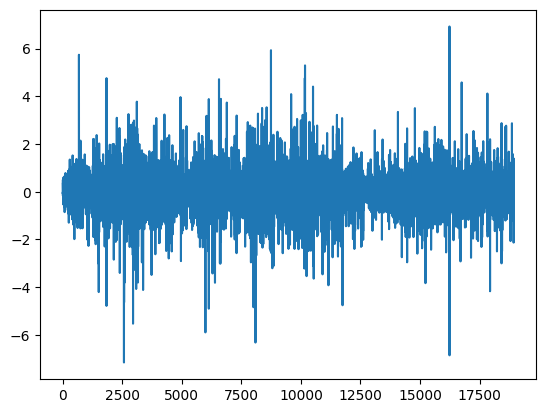

In [56]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

r2 = r2_score(y_scaled, y_pred) # RSS / TSS 
mse = mean_squared_error(y_scaled, y_pred) # mean of squared err distance 
mae = mean_absolute_error(y_scaled, y_pred) # mean of aboslute err distance

print(f"R2 Score: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

df_pred = pd.DataFrame(y_pred)
df_pred[0].plot()
plt.show()

Text(0, 0.5, 'Predicted Values')

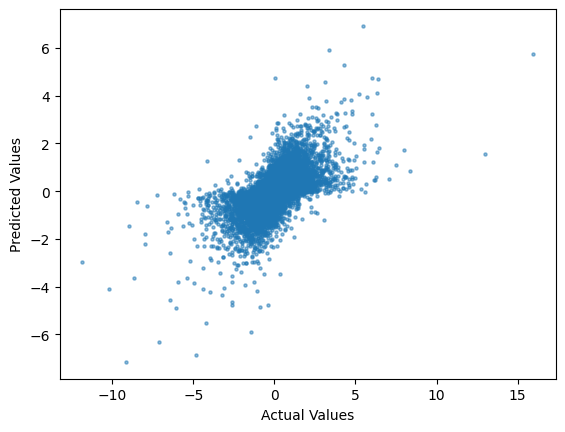

In [62]:
plt.scatter(y_scaled, y_pred, alpha=0.5, s=5)
# plt.plot([y_scaled.min(), y_scaled.max()], [y_scaled.min(), y_scaled.max()], color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

### Residuals 

##### $ \hat{u_t} = (Y_t - \hat{Y}_t) $

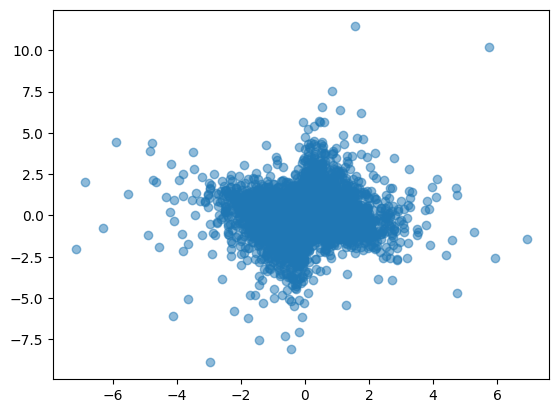

In [ ]:
plt.scatter(y_pred, y_scaled-y_pred, alpha=0.5)
plt.show()

这个 linear regression model reversion 和 ma reversion 有什么差别？ 
- time-series model reversion 
- cross-sectional model reversion